In [1]:
# import dependencies
import sys
import numpy as np
import pandas as pd

import os
print(os.getcwd())#显示当前路径
os.chdir('D:/bio/STalign/STalign-main')#更改路径，''里面为更改的路径
print(os.getcwd())#显示当前路径

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,10)  # make plots bigger

import torch
if torch.cuda.is_available():
    print('cuda is available')
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')
# import STalign after pip install
from STalign import STalign

D:\bio\jupyter_code\LICA
D:\bio\STalign\STalign-main
cuda is available


In [2]:
# param
source_dataset = 'HCC-5D'
target_dataset = 'HCC-5C'
input_dir = 'G:/dataset/LICA/input/'
output_dir = 'G:/dataset/LICA/output/STalign/'
image_path = '/spatial/tissue_hires_image.png'
position_path = '/spatial/tissue_positions_list.csv'

# image_files = ['D:/dataset/'+datasets[0]+'/spatial/tissue_hires_image.png', 'D:/dataset/'+datasets[1]+'/spatial/tissue_hires_image.png']
# position_files = ['D:/dataset/'+datasets[0]+'/spatial/tissue_positions_list.csv', 'D:/dataset/'+datasets[0]+'/spatial/tissue_positions_list.csv']

## load source_dataset

In [3]:
# load position file
df_source = pd.read_csv(input_dir + source_dataset + position_path, header=None)
print(df_source.head())
print(len(df_source))

import scanpy as sc
adata = sc.read_visium(input_dir+source_dataset)
df_source = df_source[df_source[0].isin(adata.obs.index.tolist())]
df_source = df_source.reset_index(drop=True)
del adata
print(len(df_source))

                    0  1  2  3     4     5
0  ACGCCTGACACGCGCT-1  0  0  0  2089  2663
1  TACCGATCCAACACTT-1  0  1  1  2263  2762
2  ATTAAAGCGGACGAGC-1  0  0  2  2090  2863
3  GATAAGGGACGATTAG-1  0  1  3  2264  2962
4  GTGCAAATCACCAATA-1  0  0  4  2090  3063
4992
4352


D:\anaconda\envs\STalign\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\STalign\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


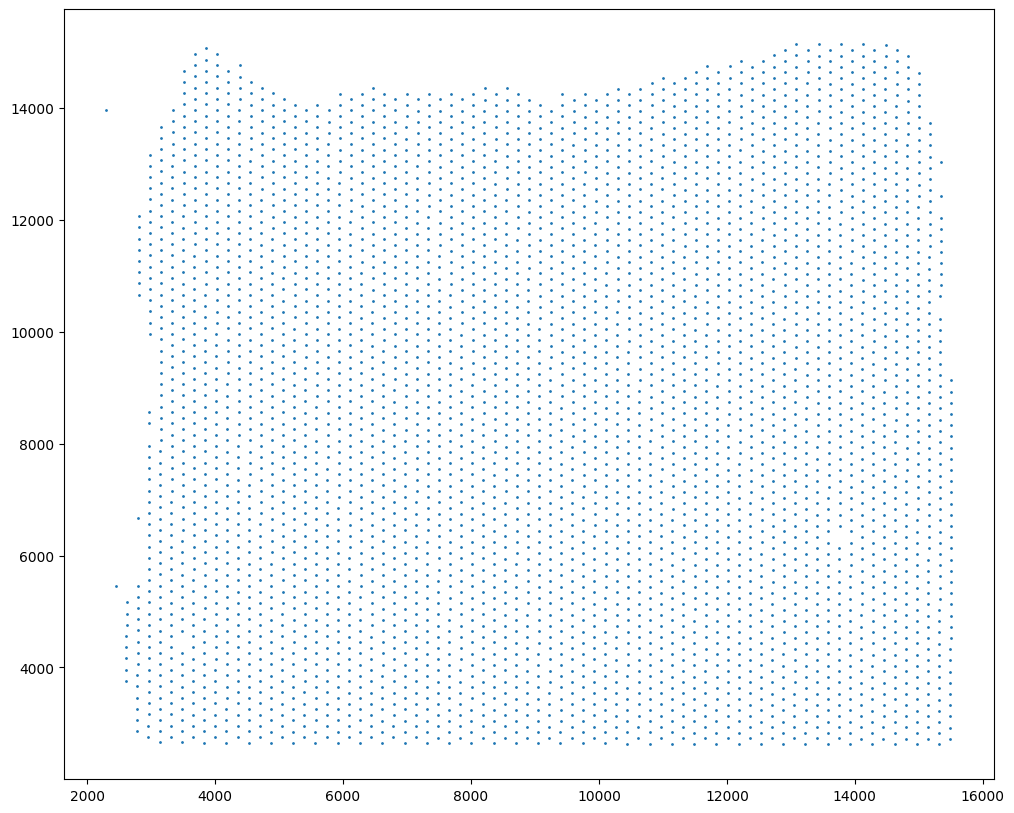

In [4]:
# get cell centroid coordinates
xI = np.array(df_source[4])
yI = np.array(df_source[5])

# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=1)

0 of 4352
4351 of 4352


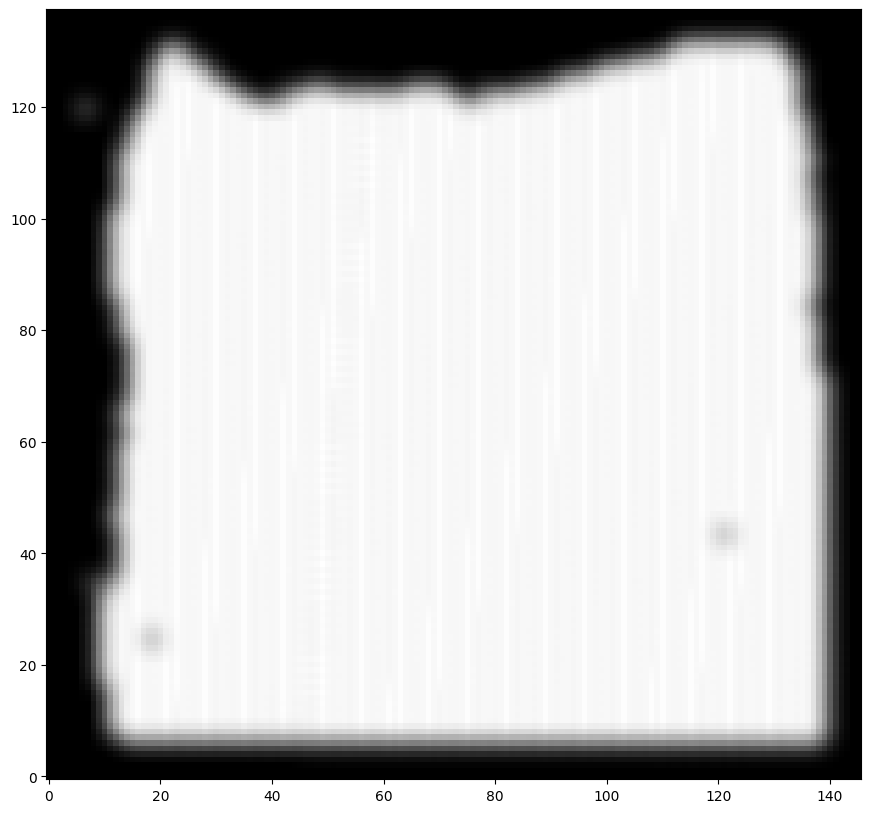

In [5]:
# rasterize at 100um resolution so image looks smooth
XI,YI,I,fig = STalign.rasterize(xI,yI,dx=100)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

## load target dataset

In [6]:
# load position file
df_target = pd.read_csv(input_dir + target_dataset + position_path, header=None)
print(df_target.head())
print(len(df_target))

import scanpy as sc
adata = sc.read_visium(input_dir+target_dataset)
df_target = df_source[df_source[0].isin(adata.obs.index.tolist())]
df_target = df_target.reset_index(drop=True)
del adata
print(len(df_target))

                    0  1  2  3     4     5
0  ACGCCTGACACGCGCT-1  0  0  0  2474  1865
1  TACCGATCCAACACTT-1  0  1  1  2648  1965
2  ATTAAAGCGGACGAGC-1  0  0  2  2474  2065
3  GATAAGGGACGATTAG-1  0  1  3  2649  2164
4  GTGCAAATCACCAATA-1  0  0  4  2475  2265
4992
3419


D:\anaconda\envs\STalign\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\STalign\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


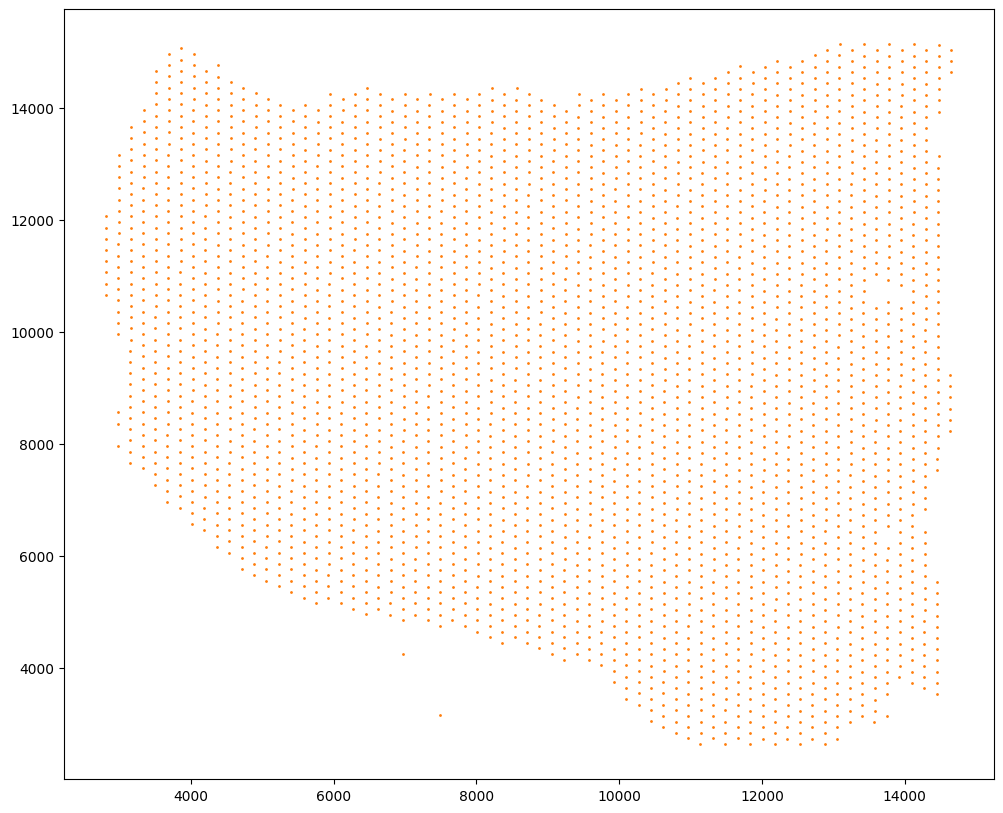

In [7]:
# get cell centroids
xJ = np.array(df_target[4])
yJ = np.array(df_target[5])

# plot
fig,ax = plt.subplots()
ax.scatter(xJ,yJ,s=1,alpha=1,c='#ff7f0e')

0 of 3419
3418 of 3419


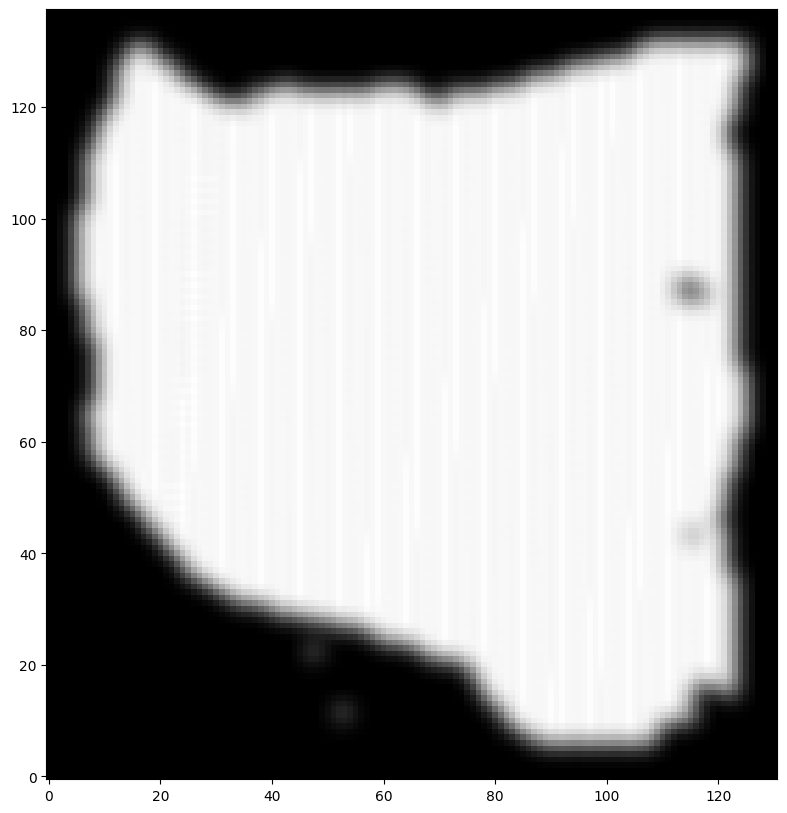

In [8]:
# rasterize and plot
XJ,YJ,J,fig = STalign.rasterize(xJ,yJ,dx=100)
ax = fig.axes[0]
ax.invert_yaxis()

### visualization

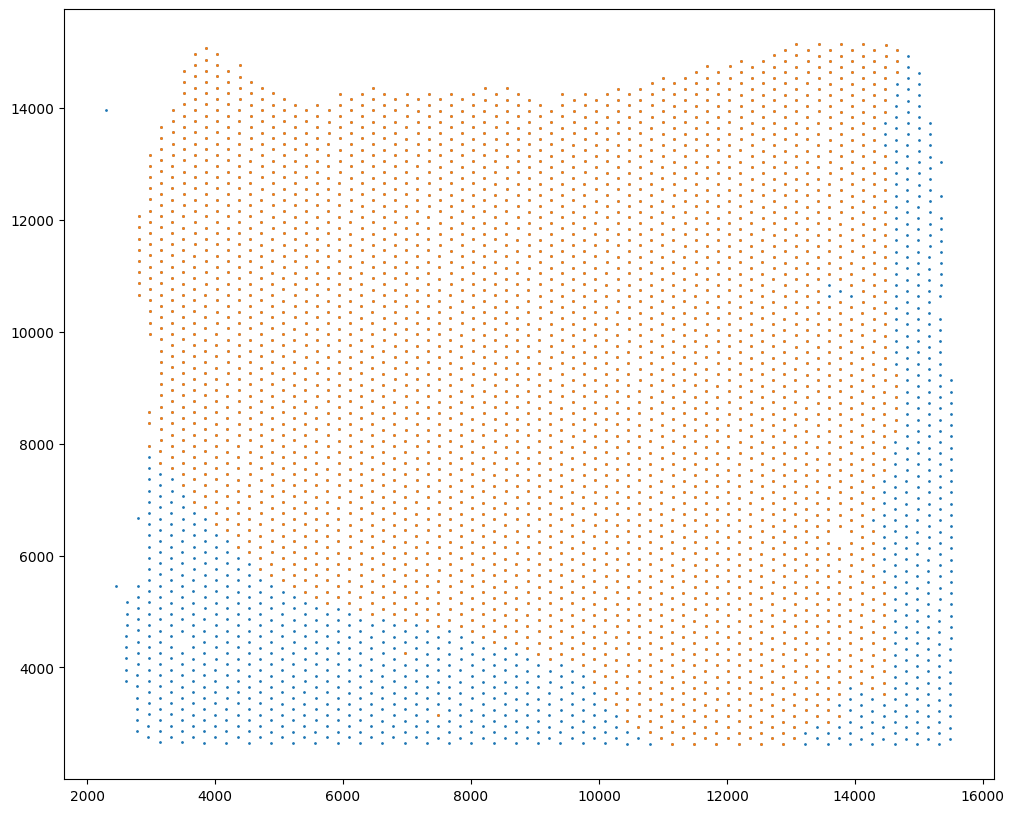

In [9]:
# plot
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=1)
ax.scatter(xJ,yJ,s=1,alpha=1)

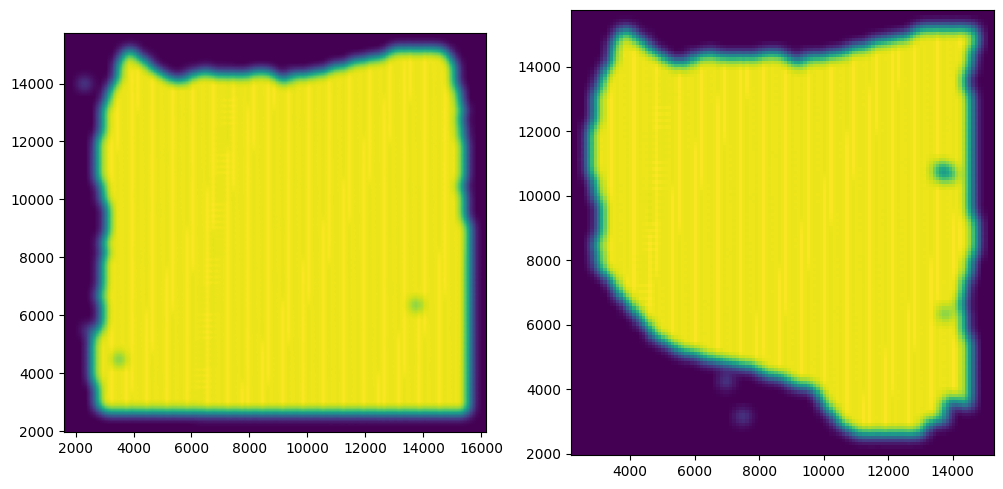

In [10]:
# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

# plot rasterized images
fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI)
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

## run STAlign

In [ ]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

Ifoo = np.vstack((I, I, I)) # make RGB instead of greyscale
Jfoo = np.vstack((J, J, J)) # make RGB instead of greyscale

out = STalign.LDDMM([YI,XI],Ifoo,[YJ,XJ],Jfoo, dtype=torch.float32,device=device)


# keep all other parameters default
# params = {
#           'niter':1000,
#           'device':device,
#           'diffeo_start':100,
#           'a':250,
#           'epV':1000,
#           'sigmaB':0.1,
#           'muB': torch.tensor([0,0,0]), # black is background in target
#           }

# out = STalign.LDDMM([YI,XI],Ifoo,[YJ,XJ],Jfoo,**params)

D:\anaconda\envs\STalign\lib\site-packages\torch\utils\_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
D:\anaconda\envs\STalign\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
D:\bio\STalign\STalign-main\STalign\STalign.py:1280: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


In [ ]:
# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']

In [ ]:
print(type(xv[0][0]))
print(xv[0].dtype)
print(type(v))
print(type(A))
print(type(YI[0]))
print(type(XI[0]))
print(type(Ifoo[0][0][0]))
print(type(YJ[0]))
print(type(XJ[0]))
print(type(XJ[0]))

In [ ]:
import importlib
importlib.reload(STalign)

In [ ]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b',dtype=torch.float32)
phiI = STalign.transform_image_atlas_to_target(xv,v,A,[YI,XI],Ifoo,[YJ,XJ],dtype=torch.float32)

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
if phii.is_cuda:
    ax.contour(XJ,YJ,phii[...,0].cpu(),colors='r',linestyles='-',levels=levels)
    ax.contour(XJ,YJ,phii[...,1].cpu(),colors='g',linestyles='-',levels=levels)
else:
    ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
    ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
if phiI.is_cuda:
    ax.imshow(phiI.cpu().permute(1,2,0)/torch.max(phiI.cpu()),extent=extentJ)
else:
    ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.invert_yaxis()

In [ ]:
# # transform is invertible
# phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
# phiiJ = STalign.transform_image_target_to_atlas(xv,v,A,[YJ,XJ],Jfoo,[YI,XI])

# # plot with grids
# fig,ax = plt.subplots()
# levels = np.arange(-100000,100000,1000)

# if phi.is_cuda:
#     ax.contour(XJ,YJ,phi[...,0].cpu(),colors='r',linestyles='-',levels=levels)
#     ax.contour(XJ,YJ,phi[...,1].cpu(),colors='g',linestyles='-',levels=levels)
# else:
#     ax.contour(XJ,YJ,phi[...,0],colors='r',linestyles='-',levels=levels)
#     ax.contour(XJ,YJ,phi[...,1],colors='g',linestyles='-',levels=levels)
# # ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
# # ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
# ax.set_aspect('equal')
# ax.set_title('target to source')
# if phiiJ.is_cuda:
#     ax.imshow(phiiJ.cpu().permute(1,2,0)/torch.max(phiiJ.cpu()),extent=extentI)
# else:
#     ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
# # ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
# ax.invert_yaxis()

In [ ]:
# apply transform to original points
tpointsI= STalign.transform_points_atlas_to_target(xv,v,A, np.stack([yI, xI], 1), dtype=torch.float32)

# switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

In [ ]:
# plot results
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
if tpointsI.is_cuda:
    ax.scatter(xI_LDDMM.cpu(),yI_LDDMM.cpu(),s=1,alpha=0.1, label = 'source aligned')
else:
    ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)

In [ ]:
if tpointsI.is_cuda:
    df_source_aligned = pd.DataFrame(
        {
            "aligned_x": xI_LDDMM.cpu(),
            "aligned_y": yI_LDDMM.cpu(),
        }
    )
else:
    df_source_aligned = pd.DataFrame(
        {
            "aligned_x": xI_LDDMM,
            "aligned_y": yI_LDDMM,
        }
    )
results = pd.concat([df_source, df_source_aligned], axis=1)
results.head()

In [ ]:
results.to_csv(output_dir + source_dataset + '_aligned_to_' + target_dataset + '.csv', sep=',')